In [1]:
import ROOT
from ROOT import RooRealVar,RooCBShape,RooDataHist,RooArgList,RooFit
from ROOT import gROOT,gStyle,gPad
from ROOT import std
import csv
import json
from array import array
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

import numpy as np


import sys
sys.path.insert(0, 'utils/')
import CBfunction as CB
reload(CB)
import CrystalMap as crystMap
reload(crystMap)
from uncertainties import unumpy
from uncertainties import ufloat
import pandas as pd

Welcome to JupyROOT 6.18/00


In [2]:
outstr = 'timeuniformity_C3_MCP2'
#trees_path = '/eos/cms/store/group/dpg_ecal/comm_ecal/upgrade/testbeam/ECALTB_H4_Oct2018/ntuples_v5/'
trees_path = '/eos/user/n/nchernya/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v7/'

dir_str = '/12_09_2019/'
plot_folder = 'plots/'+dir_str
output_folder = 'output/'+dir_str
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [3]:
dict_C3_energy_scan = {}
##Now add runs for C2,C3,C4 
reader = csv.reader(open('data/energyscans19C_and3x3.csv', 'r'))
#reader = csv.reader(open('data/energyscans19C_3x3.csv', 'r'))
for row in reader:
    run,energy,crystal,_,_,_ = row
    if ('C3' in crystal) or ('C2' in crystal) or ('C4' in crystal):
        if energy in dict_C3_energy_scan.keys() :
            dict_C3_energy_scan[energy].append(run)
        else : 
            dict_C3_energy_scan[energy] = []
            dict_C3_energy_scan[energy].append(run)        

            
## Read crystal centers prepared by Simone 
reader = csv.reader(open('data/crystalscenters.csv', 'r'))
dict_crystal_centers={}
for row in reader:
    crystal,xpos,ypos = row
    if crystal!='Crystal' :
        dict_crystal_centers[crystal] = [int(xpos),int(ypos)]
        
dict_crystal_centers['C3_3x3'] =[4,5]       
        
naming = []
for i in range(5,0,-1):
    naming.append('A%d'%i)
    naming.append('B%d'%i)
    naming.append('C%d'%i)
    naming.append('D%d'%i)
    naming.append('E%d'%i)
missing = 'A5,A4,E5,E4'.split(',')
working = [item for item in naming]
for item in missing:
    working.remove(item)
    
matrix_3 = 'B4,C4,D4,B3,C3,D3,B2,C2,D2'.split(',')
matrix_5 = 'B5,C5,D5,B4,C4,D4,B3,C3,D3,B2,C2,D2,A1,B1,C1,D1,E1'.split(',')        
matrix_3_C4 = 'B5,C5,D5,B4,C4,D4,B3,C3,D3'.split(',')        
matrix_3_C2 = 'B3,C3,D3,B2,C2,D2,B1,C1,D1'.split(',')        


energies = sorted([float(item) for item in dict_C3_energy_scan.keys()])
energies = [str(item) for item in energies]
round_energies = [round(float(energy),-1) for energy in energies]
if round_energies[-1] ==240 : round_energies[-1] = 250.

In [ ]:
dict_df_energy = {}

for energy in energies:
#for energy in [energies[-1]]:
    
    runs = dict_C3_energy_scan[energy]
    tree = ROOT.TChain("h4")
    for run in runs:
        tree.Add("%s/ECAL_H4_October2018_%s.root"%(trees_path,run))
    pos_cut = 4
    data = []
    for evt in tree:
        ############CHange e3x3 cut per energy!!!!!########
       # if evt.n_tracks==1 and evt.e3x3<10000. and evt.e3x3>8300. and evt.X[0] > -9. and evt.X[0] < 1. and evt.Y[0]>-1. and evt.Y[0]<8. : 
        if evt.n_tracks==1 and evt.X[0] > -9. and evt.X[0] < 1. and evt.Y[0]>-1. and evt.Y[0]<8. : 

            evt_dict = {}
            e = round(float(evt.Energy),-1)
            if e ==240 : e = 250.
            evt_dict['Energy'] = e
            evt_dict['run'] = run
            evt_dict['e3x3'] = evt.e3x3
            evt_dict['seed'] = evt.seed
            evt_dict['fit_ampl_MCP1'] = evt.fit_ampl[evt.MCP1]/evt.b_rms[evt.MCP1]
            evt_dict['fit_ampl_MCP2'] = evt.fit_ampl[evt.MCP2]/evt.b_rms[evt.MCP2]
            evt_dict['fit_time_MCP1'] = evt.fit_time[evt.MCP1]
            evt_dict['fit_time_MCP2'] = evt.fit_time[evt.MCP2]
            evt_dict['fit_time_VFE_CLK'] = evt.fit_time[evt.VFE_CLK]            
            for xstal in working:
                evt_dict['fit_ampl_'+xstal] = evt.fit_ampl[getattr(evt, xstal)]
                evt_dict['amp_max_'+xstal] = evt.amp_max[getattr(evt, xstal)]
                evt_dict['noise_'+xstal] = evt.b_rms[getattr(evt, xstal)]
                evt_dict['fit_time_'+xstal] = evt.fit_time[getattr(evt, xstal)]
                evt_dict['fit_terr_'+xstal] = evt.fit_terr[getattr(evt, xstal)]
                evt_dict['%s'%xstal] = getattr(evt,xstal)
            data.append(evt_dict)

    df = pd.DataFrame(data) 
    dict_df_energy[energy] = df

    pd_name = '%s/ECAL_H4_October2018_pandas_C3beamscan_full5_%s.csv'%(trees_path,int(e))
   # pd_name = '%s/ECAL_H4_October2018_pandas_C3_3x3_%s.csv'%(trees_path,int(e))
    df.to_csv(pd_name)

In [4]:
### Only used when I dont want to rerun the dataframe creation (takes longer than read csv file)
dict_df_energy = {}
for energy in round_energies[0:2]:
#for energy in energies:
    pd_name = '%s/ECAL_H4_October2018_pandas_C3beamscan_full5_%s.csv'%(trees_path,int(energy))
    print pd_name
    df = pd.read_csv(pd_name)    
    dict_df_energy[energy] = df

/eos/user/n/nchernya/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v7//ECAL_H4_October2018_pandas_C3beamscan_full5_50.csv
/eos/user/n/nchernya/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v7//ECAL_H4_October2018_pandas_C3beamscan_full5_100.csv


<Figure size 432x288 with 0 Axes>

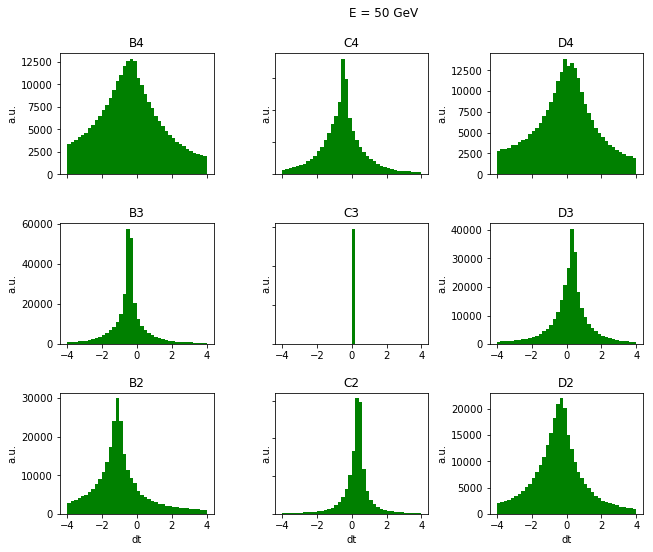

<Figure size 432x288 with 0 Axes>

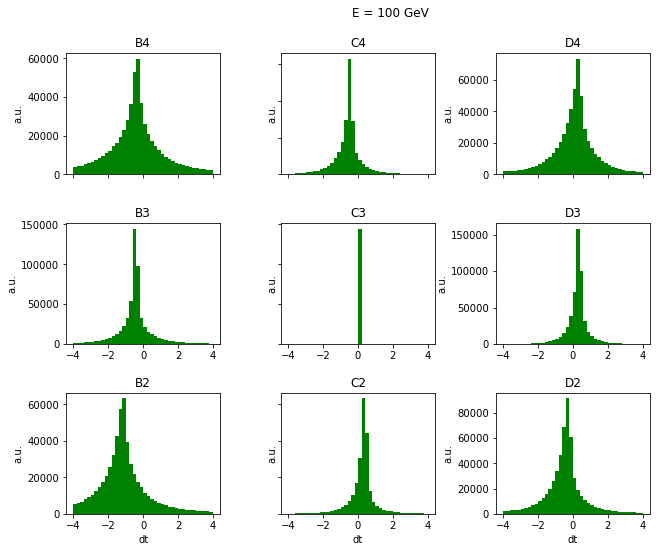

<Figure size 432x288 with 0 Axes>

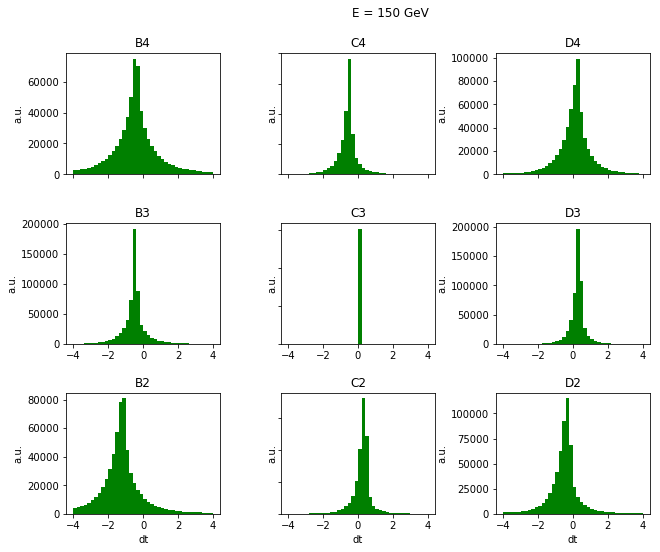

<Figure size 432x288 with 0 Axes>

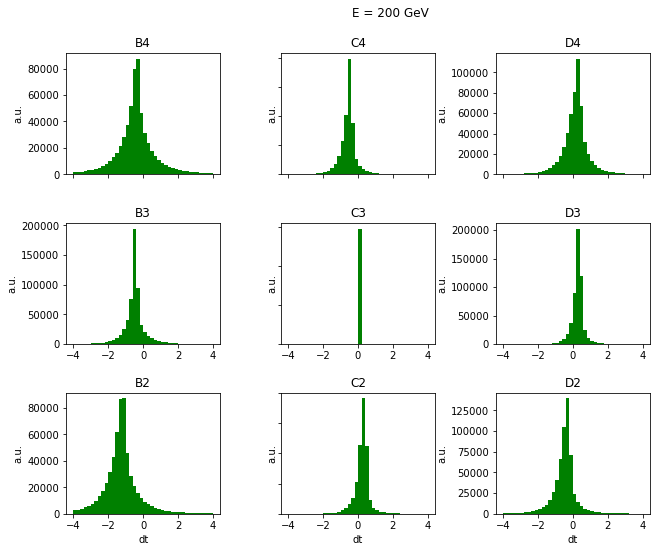

<Figure size 432x288 with 0 Axes>

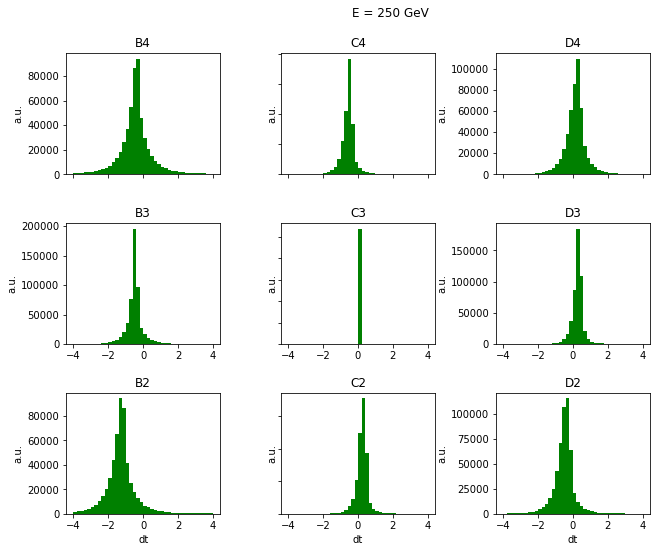

In [65]:
for num,energy in enumerate(energies):
    df = dict_df_energy[energy] 
    plt.clf()
    f, axarr = plt.subplots(3, 3)
    f.suptitle('E = %d GeV'%round_energies[num])
    DefaultSize = f.get_size_inches()
    f.set_size_inches( (DefaultSize[0]*2, DefaultSize[1]*2) )
    for i in range(0,3):
        for j in range(0,3):
            plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
            m = np.array(matrix_3).reshape(3,3)
            crystal = m[i,j]
            dt = df['fit_time_C3']-df['fit_time_%s'%crystal]
            dt = dt-(dt/6.25).astype('int32')*6.25
            axarr[i, j].hist(list(dt),range=[-4,4],bins=40,color='g')
            axarr[i, j].set_title(crystal)
            if i==2 : axarr[i, j].set_xlabel('dt')
            axarr[i, j].set_ylabel('a.u.')
    plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
    plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
    f.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()
    figname = '%s/dt_C3_crystal_%d_%s'%(plot_folder,round_energies[num],outstr)
    f.savefig(figname+'.png')
    f.savefig(figname+'.pdf')

## Per each event we want to calculate x and y of where the electron beam had it's impact

In [64]:
#crystal = 'C3'
#conditions = [
#    (df['fit_ampl_%s'%crystal] > 0 ),
#    (df['fit_ampl_%s'%crystal] <= 0)]
#choices = [df['fit_ampl_%s'%crystal], df['amp_max_%s'%crystal]]
#df['final_ampl_%s'%crystal] = np.select(conditions, choices)      
        

In [5]:
from math import log

intercalibration_file = '/eos/user/n/nchernya/SWAN_projects/ECALtestBeam/output/01_08_2019_v7/conversion_factor_v7.json'
with open('%s'%(intercalibration_file), 'r') as fp:
    dict_crystals_calibration = json.load(fp)

for num,energy in enumerate(round_energies[0:2]):
    df = dict_df_energy[int(energy)] 
    for cr in 'C2,C3,C4'.split(','):
        df['sum_3x3_%s'%cr]=0.
        if cr=='C3' :
            for crystal in matrix_3:
                df['sum_3x3_%s'%cr] += df['fit_ampl_%s'%crystal]*dict_crystals_calibration[crystal]
        elif cr=='C2' : 
            for crystal in matrix_3_C2:
                df['sum_3x3_%s'%cr] += df['fit_ampl_%s'%crystal]*dict_crystals_calibration[crystal]
        elif cr=='C4' : 
            for crystal in matrix_3_C4:
                df['sum_3x3_%s'%cr] += df['fit_ampl_%s'%crystal]*dict_crystals_calibration[crystal]

In [6]:
## loose selection
#energy_selection = [[1500,2000],[2500,4000],[4000,5900],[5000,7900],[7000,9800]]
energy_selection = [[500,2000],[500,4000],[500,5900],[500,7900],[500,9800]]
for num,energy in enumerate(round_energies[0:2]):
    df = dict_df_energy[int(energy)] 
    df = df.loc[(df['sum_3x3_C3']<energy_selection[num][1]) & (df['sum_3x3_C3']>energy_selection[num][0])]
    df = df.loc[(df['fit_ampl_MCP2']>100)]
    dict_df_energy[int(energy)] = df
    
#ranges = [[1500,2500],[2000,4500],[4000,6500],[5000,9000],[7000,10000]]
#for n,energy in enumerate(energies):
#    df = dict_df_energy[energy]
#    plt.yscale('log')
#    _,_,_ = plt.hist(df['sum_3x3'],bins=100,range=ranges[n])
#    plt.show()

In [7]:
matrix_used = matrix_3

for num,energy in enumerate(round_energies[0:2]):
    df = dict_df_energy[int(energy)] 
    
    for cr in 'C2,C3,C4'.split(','):
        df['pos_sum_w_%s'%cr]=0.
        df['ecal_x_%s'%cr]=0.
        df['ecal_y_%s'%cr]=0.
        
        if cr=='C3' : matrix_used = matrix_3
        elif cr=='C2' :  matrix_used = matrix_3_C2
        elif cr=='C4' :  matrix_used = matrix_3_C4
            
        for i in range(0,3):
            for j in range(0,3):
                m = np.array(matrix_used).reshape(3,3)
                crystal = m[i,j]    
                w = 4.2 +  np.log(df['fit_ampl_%s'%crystal]*dict_crystals_calibration[crystal]/df['sum_3x3_%s'%cr])
                w[w < 0] = 0
                df['ecal_x_%s'%cr] += ((j+1)*22-11-33)*w  # x and y are counted from C3 center (-33)
                df['ecal_y_%s'%cr] += ((i+1)*22-11-33)*w  # x and y are counted from C3 center (-33)
                df['pos_sum_w_%s'%cr] += w
    
        df['ecal_x_%s'%cr]/=df['pos_sum_w_%s'%cr]
        df['ecal_y_%s'%cr]/=df['pos_sum_w_%s'%cr]
        df['ecal_r_%s'%cr] = np.sqrt(df['ecal_x_%s'%cr]*df['ecal_x_%s'%cr] + df['ecal_y_%s'%cr]*df['ecal_y_%s'%cr])
    dict_df_energy[int(energy)] = df


/usr/local/bin/start_ipykernel.py:19: RuntimeWarning: divide by zero encountered in log
/usr/local/bin/start_ipykernel.py:19: RuntimeWarning: invalid value encountered in log


KeyError: 'ecal_x'

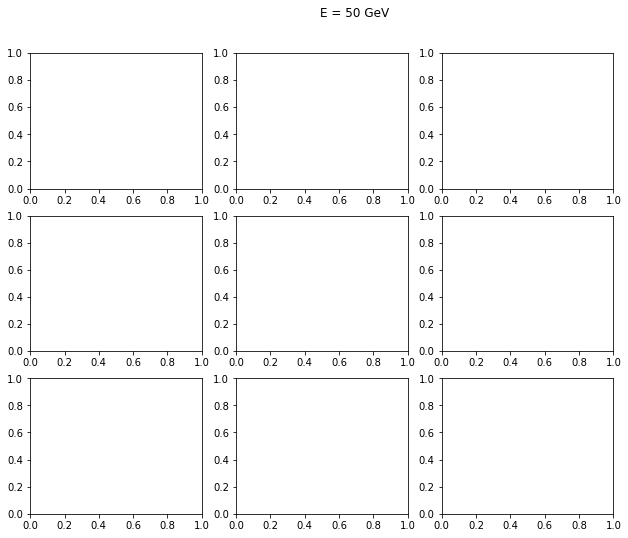

In [8]:
import seaborn as sns
from scipy.stats import crystalball
from math import sqrt
from scipy import optimize

def pol3(x, p1, p2, p3,p4):
    return p1 + p2*x + p3*x*x + p4*x*x*x


def parabola(x, p1, p2, p3):
    return p1 + p2*x + p3*x*x

def parabola_fixed(x, p1, p3):
    return p1 + p3*x*x

dict_dt_fit = {}
dict_dt_fit_3param = {}

what_to_plot = ['dt','res']
what_idx = 0

#for num,energy in enumerate(round_energies[3:5]):
for num,energy in enumerate(round_energies[0:2]):
    df = dict_df_energy[int(energy)] 

    dict_dt_fit[int(energy)] = {}
    dict_dt_fit_3param[int(energy)] = {}

    f, axarr = plt.subplots(3, 3)
    DefaultSize = f.get_size_inches()
    f.set_size_inches( (DefaultSize[0]*2, DefaultSize[1]*2) )
    f.suptitle('E = %d GeV'%energy)
    
    # dr_samples = np.linspace(0, 20.0, num=10)
    #dr_samples = [0,2,3,4,5,6,7,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,14,15,16,17,18]
    dr_samples = [0,2,3,4,5,6,7,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,14,15]   
    dr_samples = np.linspace(0, 12.0, num=12)    
    crystals_times_data = []

    for i in range(0,3):
        for j in range(0,3):
            plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
            m = np.array(matrix_3).reshape(3,3)
            crystal = m[i,j]
            #dt = df['fit_time_C3']-df['fit_time_%s'%crystal]
            #df['dt_C3_%s'%crystal] = dt - ((dt/6.25).astype('int32')*6.25)
            dt =  df['fit_time_%s'%crystal]-df['fit_time_MCP2']+df['fit_time_VFE_CLK']
            df['dt_ecal_MCP_%s'%crystal] = dt - ((dt/6.238).astype('int32')*6.238)
            df['dr_%s'%crystal] = np.sqrt(np.power((df['ecal_x']-((j+1)*22-11-33)),2) + np.power((df['ecal_y']-((i+1)*22-11-33)),2))            
            
          #  distance = 18
          #  if (j-1)==0 and (i-1)==0 :
          #      subdf = df[(df['seed']==df['C3'])] #& (df['seed']==df['%s'%crystal])           
          #  elif (j-1)==0 :
          #      subdf = df[(df['ecal_x'] < distance) & (df['ecal_x'] > -distance) & (df['ecal_y']*np.sign(i-1) > 0 ) & ((df['seed']==df['%s'%crystal]) | (df['seed']==df['C3']))] #& (df['seed']==df['%s'%crystal])
          #  elif (i-1)==0 :
          #      subdf = df[(df['ecal_y'] < distance) & (df['ecal_y'] > -distance) & (df['ecal_x']*np.sign(j-1) > 0 ) & ((df['seed']==df['%s'%crystal]) | (df['seed']==df['C3']))]
          #  else : 
          #      subdf = df[(df['ecal_y']*np.sign(i-1) > 0) & (df['ecal_x']*np.sign(j-1) > 0 )& ((df['seed']==df['%s'%crystal]) | (df['seed']==df['C3'])) ]
         #   subdf = df[(df['seed']==df['%s'%crystal]) | (df['seed']==df['C3']) ]

         #   subdf = df[(df['seed']==df['%s'%crystal]) | (df['seed']==df['C3']) ]
            #subdf = df
            
            x_center = (j+1)*22-11-33
            y_center = (i+1)*22-11-33
            subdf = df.loc[ (df['ecal_x']<(x_center+9)) & (df['ecal_x']>(x_center-9)) &(df['ecal_y']<(y_center+9)) & (df['ecal_y']>(y_center-9))   ] 

           # sns.regplot(x=subdf['ecal_r'], y=subdf['dt_C3_%s'%crystal], x_bins=20, fit_reg=None,ax=axarr[i, j]) 
            delta_ts_cb_mean = []
            delta_ts_cb_mean_err = []
            delta_ts_cb_std = []
            delta_ts_cb_std_err = []
            dr_samples_bins = []        
        
            for num_dr in range(0,len(dr_samples)-1):
                dr_samples_bins.append(dr_samples[num_dr]+(dr_samples[num_dr+1]-dr_samples[num_dr])/2.)
                subdf_r = subdf.loc[(subdf['dr_%s'%crystal]<dr_samples[num_dr+1]) & (subdf['dr_%s'%crystal]>dr_samples[num_dr])]
                subdf_r = subdf_r.loc[(subdf_r['dt_ecal_MCP_%s'%crystal]<2) & (subdf_r['dt_ecal_MCP_%s'%crystal]>0.3)]   #2 - 3 for mcp1, 0.3-2 for mcp2
                subdf_r = subdf_r.loc[np.abs(subdf_r['dt_ecal_MCP_%s'%crystal]-subdf_r['dt_ecal_MCP_%s'%crystal].median())<3*subdf_r['dt_ecal_MCP_%s'%crystal].std()]                
                serie = subdf_r['dt_ecal_MCP_%s'%crystal]
        
                #serie = subdf_r['dt_ecal_MCP1_%s'%crystal]
        #        delta_ts_cb_mean.append(serie.mean())
              #  if crystal=='C3' or (serie.shape[0]<100):
                if (crystal!='C3') or (crystal!='C2') or (crystal!='C4') or (serie.shape[0]<100):
                    loc = serie.median()
                    scale = serie.std()
                    if serie.shape[0]!=0 : 
                        time_err = serie.std()/sqrt(serie.shape[0])
                    else : time_err=8 
                else :  
                    beta, cb_m, loc, scale = crystalball.fit(serie,loc=serie.median(),scale=serie.std())
                    time_err = serie.std()/sqrt(serie.shape[0])
                #if crystal=='C3':
                #    loc = serie.median()
                #    scale = serie.std()
                delta_ts_cb_mean_err.append(time_err)
                delta_ts_cb_mean.append(loc)
                delta_ts_cb_std.append(scale)
        

            if crystal!='C3': 
            #if (1>0): 
                if what_to_plot[what_idx] == 'dt' :
                    axarr[i, j].errorbar(dr_samples_bins, delta_ts_cb_mean, yerr=delta_ts_cb_mean_err, marker='*', linestyle='',color='g')
                  #  params, params_covariance = optimize.curve_fit(parabola, np.array(dr_samples_bins)[np.array(dr_samples_bins)<15], np.array(delta_ts_cb_mean)[np.array(dr_samples_bins)<15],absolute_sigma=True, sigma=np.array(delta_ts_cb_mean_err)[np.array(dr_samples_bins)<15])
                  #  if crystal=='C3': axarr[i, j].plot(dr_samples_bins, parabola(np.array(dr_samples_bins), params[0], params[1],params[2]),color='r',label = 'pol2') #'p0=%.5f,\np1=%.5f,\np2=%.5f'%(params[0], params[1],params[2]))
                
                  #  params2, params_covariance2 = optimize.curve_fit(parabola_fixed, np.array(dr_samples_bins)[np.array(dr_samples_bins)<15], np.array(delta_ts_cb_mean)[np.array(dr_samples_bins)<15],absolute_sigma=True, sigma=np.array(delta_ts_cb_mean_err)[np.array(dr_samples_bins)<15])
                   # if crystal=='C3': axarr[i, j].plot(dr_samples_bins, parabola_fixed(np.array(dr_samples_bins), params2[0], params2[1]),color='b',label = 'fixed pol2') #'p0=%.3f,\np2=%.5f'%(params2[0], params2[1]))
                        
                   # params3, params_covariance3 = optimize.curve_fit(pol3, np.array(dr_samples_bins)[np.array(dr_samples_bins)<15], np.array(delta_ts_cb_mean)[np.array(dr_samples_bins)<15],absolute_sigma=True, sigma=np.array(delta_ts_cb_mean_err)[np.array(dr_samples_bins)<15])
                   # if crystal=='C3': axarr[i, j].plot(dr_samples_bins, pol3(np.array(dr_samples_bins), params3[0], params3[1],params3[2],params3[3]),color='m',label = 'pol3')
  
                        
                    dict_dt_fit[int(energy)]['%s'%crystal] = {'p0':params2[0],'p2':params2[1]}
                    dict_dt_fit_3param[int(energy)]['%s'%crystal] = {'parabola':{'p0':params[0],'p1':params[1],'p2':params[2]},'pol3':{'p0':params3[0],'p1':params3[1],'p2':params3[2],'p3':params3[3]}}

                    
                    #crystals_times_data.append([(item-params2[0]) for item in delta_ts_cb_mean])
                    crystals_times_data.append([(parabola_fixed(item, params2[0], params2[1])- params2[0]) for item in dr_samples_bins])
                    #crystals_times_data.append([(parabola(item, params[0], params[1],params[2])- params[0]) for item in dr_samples_bins])
    
                else : axarr[i, j].plot(dr_samples_bins, delta_ts_cb_std, marker='*', linestyle='',color='g')

                
            axarr[i, j].set_title(crystal)
            axarr[i, j].set_xlabel('Ecal dr')
            if what_to_plot[what_idx] == 'dt' : axarr[i, j].set_ylabel('dt')
            else : axarr[i, j].set_ylabel('time resolution')
            axarr[i, j].legend(loc='upper left')
        
  #  axarr[1, 1].set_title('All Crystals')        
  #  out = axarr[1, 1].plot(np.array(dr_samples_bins), np.array(crystals_times_data).transpose())
  #  axarr[1, 1].legend(iter(out),np.array(list(filter(lambda x: x!= 'C3', matrix_3))),loc='upper left')
        
    f.subplots_adjust(wspace=0.5, hspace=0.4)
    plt.show()
    if what_to_plot[what_idx] == 'dt' : 
        figname = '%s/dt_r_crystal_18_energy%d_%s'%(plot_folder,energy,outstr)
        with open('%s/dt_fit_parabola_energy%d_%s.json'%(output_folder,energy,outstr), 'w') as fp:
            json.dump(dict_dt_fit, fp)
        with open('%s/dt_fit_res_%s_%s.json'%(output_folder,energy,outstr), 'w') as fp:
            json.dump(dict_dt_fit_3param, fp)
    else :  
        figname = '%s/timeres_r_crystal_18_energy%d_%s'%(plot_folder,energy,outstr)
    
    f.savefig(figname+'.png')
    f.savefig(figname+'.pdf')

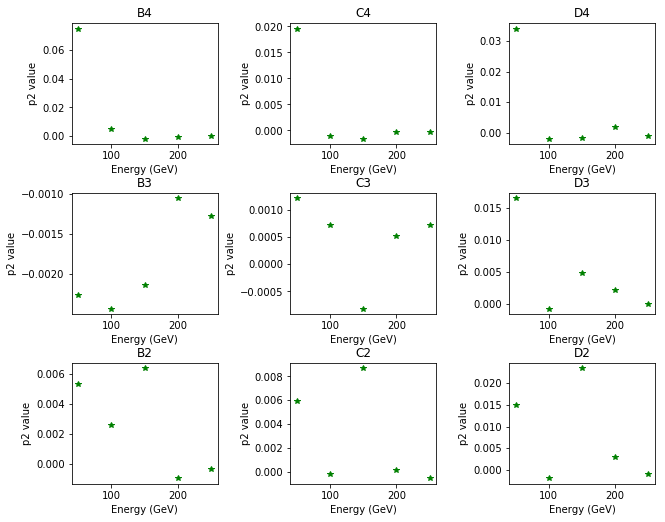

In [35]:
f, axarr = plt.subplots(3, 3)
DefaultSize = f.get_size_inches()
f.set_size_inches( (DefaultSize[0]*2, DefaultSize[1]*2) )
    
for i in range(0,3):
    for j in range(0,3):
        plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        m = np.array(matrix_3).reshape(3,3)
        crystal = m[i,j]
        
        #if crystal!='C3': 
        if crystal!='AAAAA': 
            axarr[i, j].plot(round_energies,map(lambda x: dict_dt_fit[x][crystal]['p2'],  round_energies) , marker='*', linestyle='',color='g')
       # axarr[i, j].set_ylim([0.00001,0.0015]) 
        axarr[i, j].set_title(crystal)
        axarr[i, j].set_ylabel('p2 value')
        axarr[i, j].set_xlabel('Energy (GeV)')
        #axarr[i, j].legend(loc='upper left')

f.subplots_adjust(wspace=0.5, hspace=0.4)
plt.show()
figname = '%s/dt_r_fitparams_crystal_energy%d_%s'%(plot_folder,energy,outstr)
f.savefig(figname+'.png')
f.savefig(figname+'.pdf')

In [40]:
with open('%s/fit_res_%s.json'%(output_folder,outstr), 'w') as fp:
    json.dump(dict_dt_fit_3param, fp)

In [60]:
for num,energy in enumerate(round_energies[3:5]):
#for num,energy in enumerate(round_energies):
    df = dict_df_energy[int(energy)] 
    
    values = pol3(np.array(df['dr_C3']), dict_dt_fit_3param[energy]['C3']['pol3']['p0'], dict_dt_fit_3param[energy]['C3']['pol3']['p1'],dict_dt_fit_3param[energy]['C3']['pol3']['p2'],dict_dt_fit_3param[energy]['C3']['pol3']['p3'])
    df['fit_time_ecal_MCP_C3_subtracted'] = df['dt_ecal_MCP_C3']  - values
    
    #for crystal in list(filter(lambda x: x!= 'C3', matrix_3)):
    #    df['fit_time_%s_subtracted'%crystal] = df['fit_time_%s'%crystal] - parabola_fixed(np.array(df['ecal_r']), dict_dt_fit[energy][crystal]['p0'], dict_dt_fit[energy][crystal]['p2'])

In [146]:
def time_res_crystal(x, n= 1.07332e+04  ,c = 20.):
    return np.sqrt(n*n/(x*x) + c*c)

for num,energy in enumerate(round_energies[3:5]):
#for num,energy in enumerate(round_energies):
    df = dict_df_energy[int(energy)] 
    df['sum_time_crystals']=0.
    df['sum_inv_res']=0.
    for crystal in ['C3']:
        resolution = time_res_crystal((df['fit_ampl_%s'%crystal]*dict_crystals_calibration[crystal]/df['noise_C3']).values)
        df['sum_inv_res']+=1./resolution
        if crystal!='C3' :
            df['sum_time_crystals'] += df['fit_time_%s_subtracted'%crystal]/resolution
        else : 
            df['sum_time_crystals'] += df['fit_time_%s'%crystal]/resolution
    df['sum_time_crystals']/=df['sum_inv_res']

/usr/local/bin/start_ipykernel.py:2: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':


200.0 dt_ecal_MCP_C3 results :  2.0341402709288383 4.375245280165455 1.181217686315607 0.07498727793186274


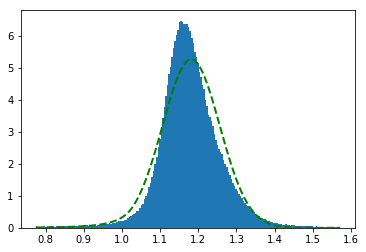

250.0 dt_ecal_MCP_C3 results :  2.007742140069287 4.948586124252399 1.1786395175276283 0.07241789805937426


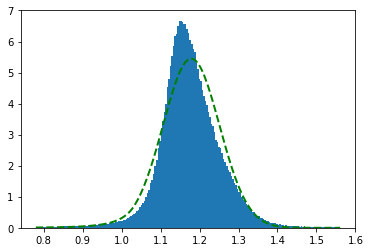

In [80]:
import matplotlib.mlab as mlab
from scipy.stats import norm

what = 'fit_time_ecal_MCP_C3_subtracted'
#what = 'dt_ecal_MCP_C3'
for num,energy in enumerate(round_energies[3:5]):
#for num,energy in enumerate(round_energies):
    df = dict_df_energy[int(energy)]
    #subdf = df.loc[(df['sum_time_crystals']>500) & (df['sum_time_crystals']<600) & (df['seed'] == df['C3'])]
    #beta, cb_m, loc, scale = crystalball.fit(subdf['sum_time_crystals'],loc=subdf['sum_time_crystals'].median(),scale=subdf['sum_time_crystals'].std())
    #n,bins,_ = plt.hist(df['fit_time_C3'],bins=50)
    #y = crystalball.pdf( bins, beta, cb_m, loc, scale)
    #l = plt.plot(bins, y, 'g--', linewidth=2)
    #plt.show()
    
    
   #subdf = df.loc[(np.abs(df['%s'%what])<0.3)]
    loc = subdf['%s'%what].median()
    std = subdf['%s'%what].std()
    subdf = df.loc[(np.abs(df['%s'%what]-loc)<5*std)]
    loc = subdf['%s'%what].median()
    std = subdf['%s'%what].std()
    subdf = df.loc[(np.abs(df['%s'%what]-loc)<5*std)]

    
    n,bins,_ = plt.hist(subdf['%s'%what],bins=200,density=1)
    beta, cb_m, loc, scale = crystalball.fit(subdf['%s'%what],loc=loc,scale=scale)
    y = crystalball.pdf( bins, beta, cb_m, loc, scale)
    #(mu, sigma) = norm.fit(subdf['fit_time_ecal_MCP_C3_subtracted'],loc=loc,scale=scale)
    #y = mlab.normpdf( bins, mu, sigma)
    l = plt.plot(bins, y, 'g--', linewidth=2)
    print energy, what, 'results : ',beta, cb_m, loc, scale
    plt.show()

200.0 fit_time_ecal_MCP_C3_subtracted results :  1.3794340925538937 9.765936869050918 -0.0021610510935464117 0.05865450205215908

    
250.0 fit_time_ecal_MCP_C3_subtracted results :  1.2669651341521118 12.691915537886883 -0.0009681877788993497 0.05389307239862046


200.0 fit_time_ecal_MCP_C3_subtracted results :  1.400708063733222 8.788834436443798 -0.0022229705576244465 0.05904117454342016


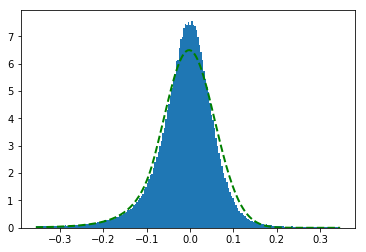

250.0 fit_time_ecal_MCP_C3_subtracted results :  1.2691649794401525 12.53430541248113 -0.0009797721380539522 0.053929201290262616


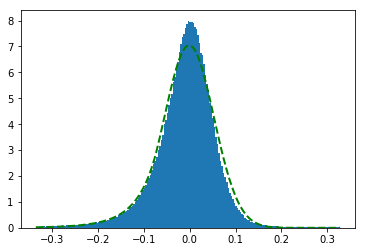

In [88]:
import matplotlib.mlab as mlab
from scipy.stats import norm

what = 'fit_time_ecal_MCP_C3_subtracted'
#what = 'dt_ecal_MCP_C3'
for num,energy in enumerate(round_energies[3:5]):
#for num,energy in enumerate(round_energies):
    df = dict_df_energy[int(energy)]
    #subdf = df.loc[(df['sum_time_crystals']>500) & (df['sum_time_crystals']<600) & (df['seed'] == df['C3'])]
    #beta, cb_m, loc, scale = crystalball.fit(subdf['sum_time_crystals'],loc=subdf['sum_time_crystals'].median(),scale=subdf['sum_time_crystals'].std())
    #n,bins,_ = plt.hist(df['fit_time_C3'],bins=50)
    #y = crystalball.pdf( bins, beta, cb_m, loc, scale)
    #l = plt.plot(bins, y, 'g--', linewidth=2)
    #plt.show()
    
    
   #subdf = df.loc[(np.abs(df['%s'%what])<0.3)]
    loc = subdf['%s'%what].median()
    std = subdf['%s'%what].std()
    subdf = df.loc[(np.abs(df['%s'%what]-loc)<5*std)]
    loc = subdf['%s'%what].median()
    std = subdf['%s'%what].std()
    subdf = df.loc[(np.abs(df['%s'%what]-loc)<5*std)]

    
    n,bins,_ = plt.hist(subdf['%s'%what],bins=200,density=1)
    beta, cb_m, loc, scale = crystalball.fit(subdf['%s'%what],loc=loc,scale=scale)
    y = crystalball.pdf( bins, beta, cb_m, loc, scale)
    #(mu, sigma) = norm.fit(subdf['fit_time_ecal_MCP_C3_subtracted'],loc=loc,scale=scale)
    #y = mlab.normpdf( bins, mu, sigma)
    l = plt.plot(bins, y, 'g--', linewidth=2)
    print energy, what, 'results : ',beta, cb_m, loc, scale
    plt.show()

In [81]:
dt =  df['fit_time_C3']-df['fit_time_MCP2']+df['fit_time_VFE_CLK']
df['test'] = dt - ((dt/6.238).astype('int32')*6.238)

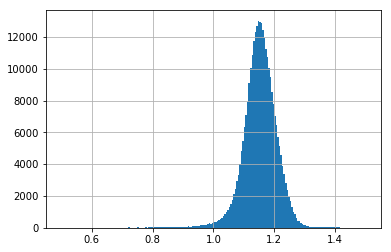

In [85]:
df.loc[df['seed']==df['C3']]['test'].hist(bins=200,range=[0.5,1.5])

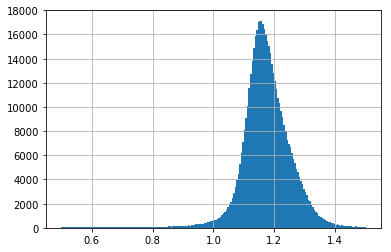

In [87]:
df['test'].hist(bins=200,range=[0.5,1.5])

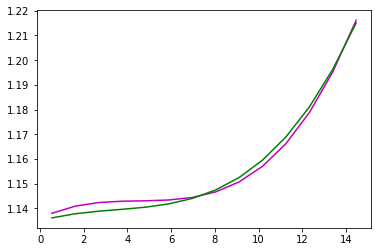

In [89]:
energy=200
plt.plot(dr_samples_bins, pol4(np.array(dr_samples_bins), dict_dt_fit_3param[energy]['C3']['pol4']['p0'], dict_dt_fit_3param[energy]['C3']['pol4']['p1'],dict_dt_fit_3param[energy]['C3']['pol4']['p2'],dict_dt_fit_3param[energy]['C3']['pol4']['p3']),color='m',label = '200 GeV')
energy=250
plt.plot(dr_samples_bins, pol4(np.array(dr_samples_bins), dict_dt_fit_3param[energy]['C3']['pol4']['p0'], dict_dt_fit_3param[energy]['C3']['pol4']['p1'],dict_dt_fit_3param[energy]['C3']['pol4']['p2'],dict_dt_fit_3param[energy]['C3']['pol4']['p3']),color='g',label = '250 GeV')
plt.show()

In [93]:
df = dict_df_energy[250] 
i=0
j=1
x_center = (j+1)*22-11-33
y_center = (i+1)*22-11-33
print x_center,y_center
subdf = df.loc[ (df['ecal_x']<(x_center+11)) & (df['ecal_x']>(x_center-11)) &(df['ecal_y']<(y_center+11)) & (df['ecal_y']>(y_center-11))   ] 



0 -22


In [38]:
subdf.loc[subdf['dr_C3']>12.][['ecal_x','ecal_y','ecal_r','dr_C3']]

,ecal_x,ecal_y,ecal_r,dr_C3
1019,8.527712,9.081858,12.458010,12.458010
4497,9.413141,7.782132,12.213468,12.213468
4970,8.243099,8.887296,12.121581,12.121581
5312,9.144862,8.170127,12.262931,12.262931
5739,9.831623,-8.159540,12.776498,12.776498
8328,6.748545,10.476286,12.461759,12.461759
11926,10.175482,6.753267,12.212578,12.212578
14065,-7.657862,-10.245607,12.791220,12.791220
14416,8.377278,8.780888,12.136012,12.136012
15198,8.592875,8.597203,12.155221,12.155221


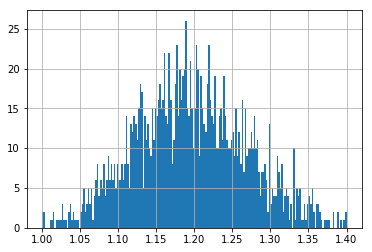

In [55]:
subdf.loc[(df['dr_C2']<14.) & (df['dr_C3']>13.)]['dt_ecal_MCP_C3'].hist(bins=200,range=[1.00,1.4])
plt.show()

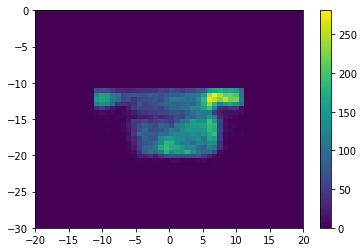

In [94]:
h=plt.hist2d(subdf['ecal_x'],subdf['ecal_y'], range=[[-20,20],[-30,0]], bins=(50,50))
plt.colorbar()

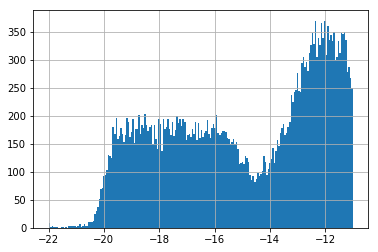

In [95]:
subdf['ecal_y'].hist(bins=200)